In [14]:
from retrieve import Basket
from retrieve import GetTicker
import bt

symbols = list(Basket().get_portfolio().keys())

symbols.extend(GetTicker().recommend_tickers())
symbols

# df = bt.get(symbols,start="2020-01-01")

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ECC%20%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ECC+++++++++++&crumb=Wj8KbGJ7I1T
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SFM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SFM&crumb=Edge%3A+Not+Found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SEIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SEIC&crumb=Edge%3A+Not+Found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SEAT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2C

['CDLX',
 'CVX',
 'PYPL',
 'MOD',
 'CALM',
 'INDA',
 'ANF',
 'YMM',
 'CORT',
 'DLO',
 'GNTX',
 'INCY']

In [17]:
import yfinance as yf

yf.Ticker("META").info

{'address1': '1 Meta Way',
 'city': 'Menlo Park',
 'state': 'CA',
 'zip': '94025',
 'country': 'United States',
 'phone': '650 543 4800',
 'website': 'https://investor.fb.com',
 'industry': 'Internet Content & Information',
 'sector': 'Communication Services',
 'longBusinessSummary': 'Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends, family, communities, and businesses across platforms and devices through text, audio, and video calls; and Wha

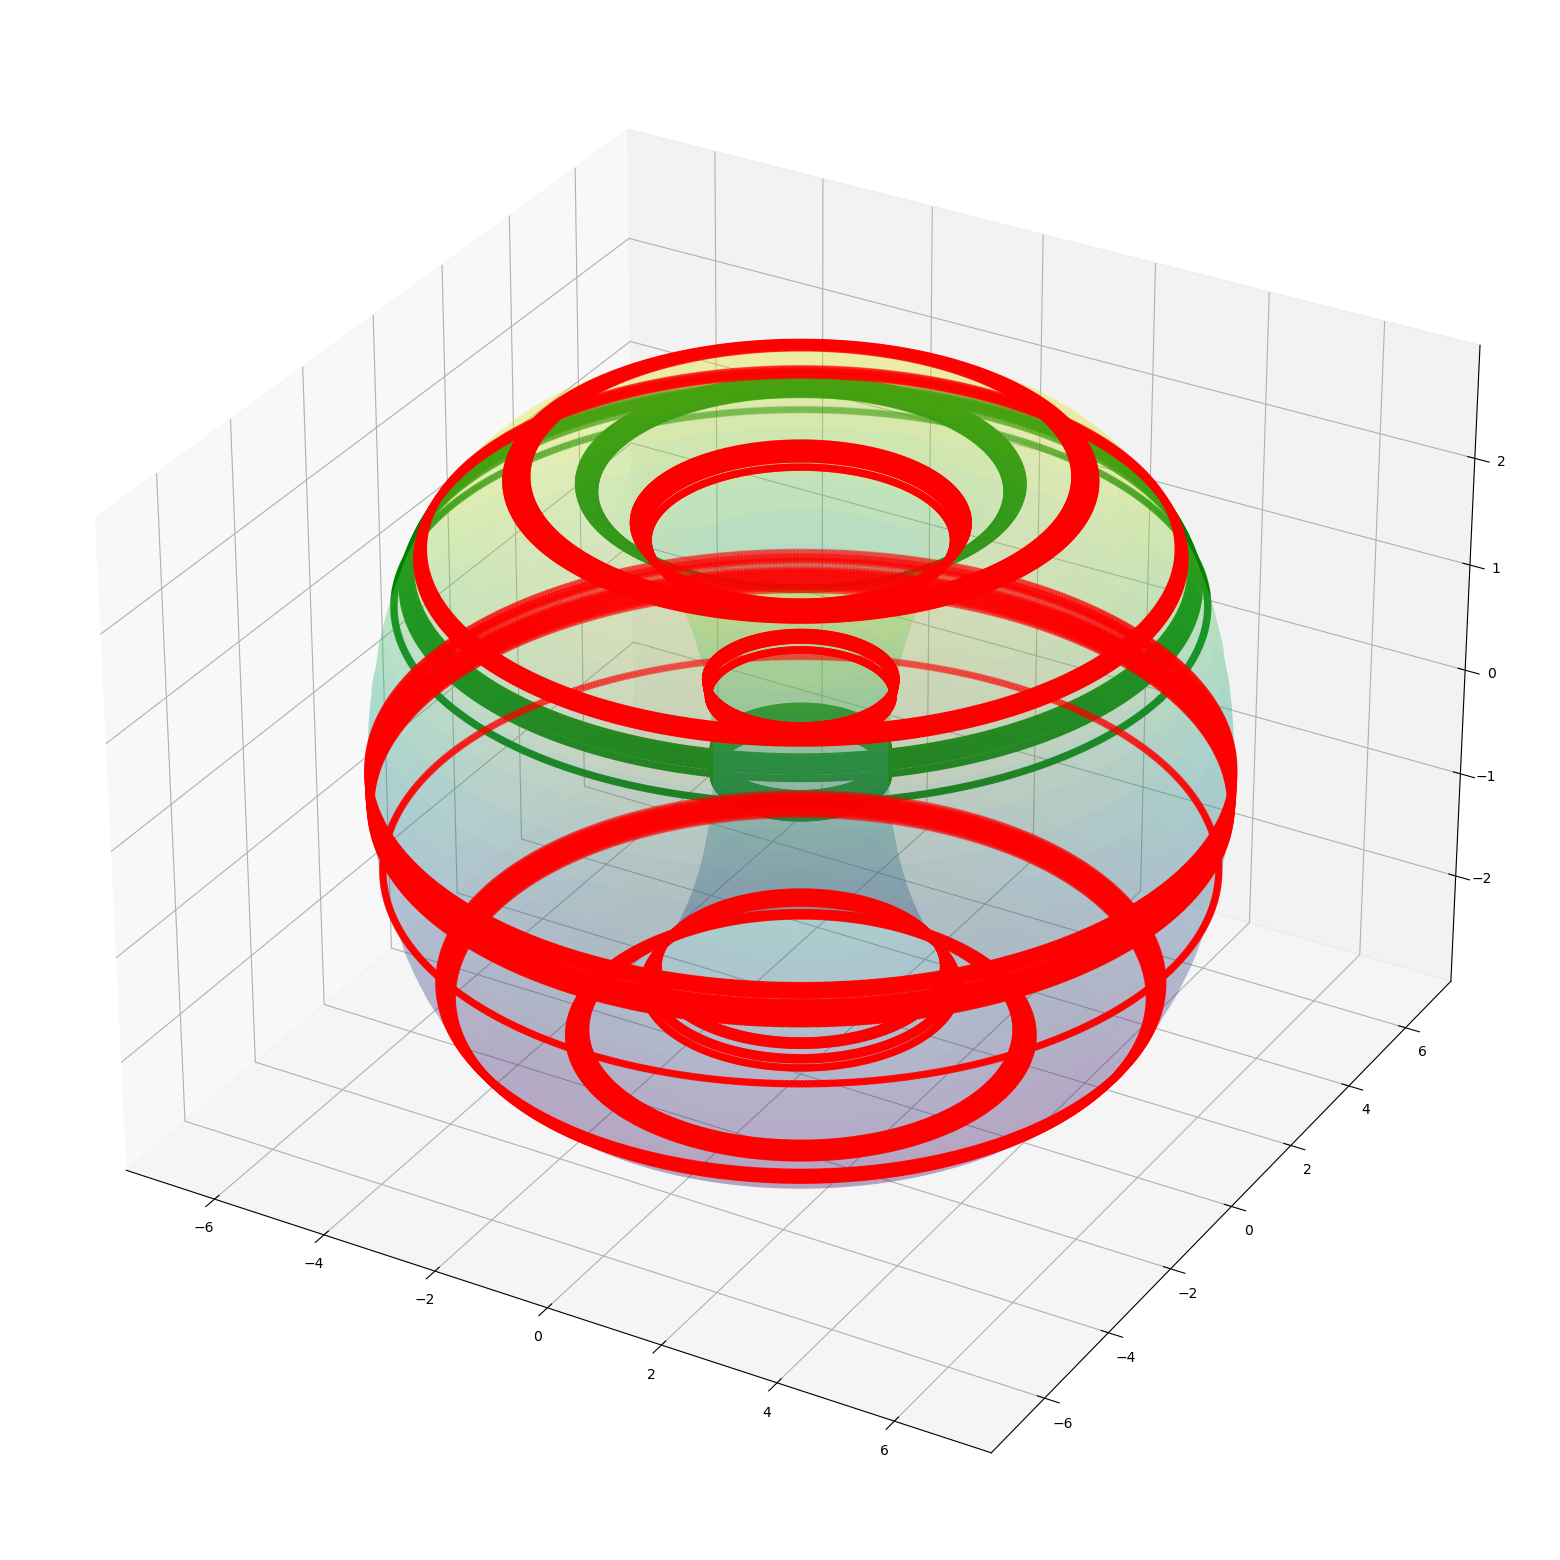

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

big = 2*np.pi

df_filter = df - df.iloc[0]

norm_price = (df_filter - df_filter.min()) / (df_filter.max() - df_filter.min()) * big

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

plot_torus("cort",big,rolling_mean,rolling_std,buy_signal,sell_signal,len(df))

In [5]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action.iloc[51:]

,cdlxSignal,cvxSignal,pyplSignal,modSignal,calmSignal,indaSignal,anfSignal,ymmSignal,cortSignal,dloSignal,gntxSignal,incySignal
Date,,,,,,,,,,,,
2021-09-03,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-07,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-08,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-09,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold
2021-09-10,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Sell,Hold,Hold,Hold
2024-05-29,Hold,Hold,Buy,Hold,Hold,Hold,Sell,Hold,Sell,Hold,Hold,Hold
2024-05-30,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Sell,Hold,Hold,Hold


In [13]:
strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.get_security_weights()

sellTailAction
0% [############################# ] 100% | ETA: 00:00:00

,inda,calm,cvx,gntx,anf,cort,incy,cdlx,mod,ymm,pypl,dlo
2021-09-02,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-03,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-07,0.500000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-08,0.500000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-09,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,0.000000,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-29,0.000000,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-30,0.000000,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-31,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Equity Progression'}>

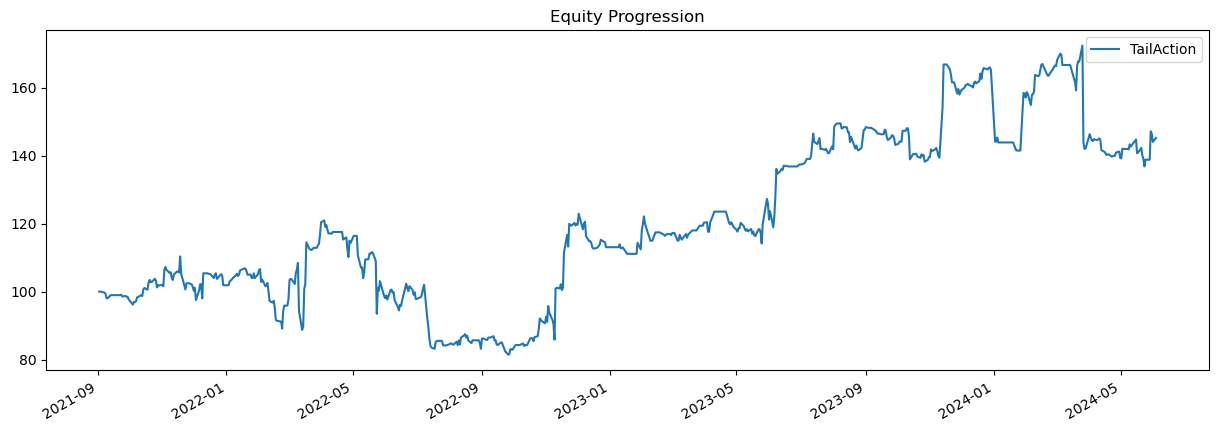

In [12]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1, df.iloc[51:,:],integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df.iloc[51:,:],
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [8]:
res.stats

,TailAction
start,2021-09-02 00:00:00
end,2024-06-03 00:00:00
rf,0.0
total_return,0.451803
cagr,0.145098
max_drawdown,-0.326449
calmar,0.444473
mtd,0.00807
three_month,-0.136439
six_month,-0.088424


import json
import requests
import os
import yfinance as yf

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

tickers = list(criteria["Portfolio Weights"].keys())

for stock_ex in criteria["Exchanges"]:
    github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
    exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

    url = github_branch + exchange # combining the repository dataset with the specific exchange

    resp = requests.get(url)
    data = json.loads(resp.text)

    for i in range(len(data)):
        ticker = data[i]

        immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
        # important to note that since the list of tickers is massive, need to find any method to narrow scope

        # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
        if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
            continue

        # numeric comparison
        lastsale = float(ticker[immediate_criteria[0]][1:])
        volume = float(ticker[immediate_criteria[1]])
        marketCap = float(ticker[immediate_criteria[2]])

        # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
        check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
            and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
        check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

        if check_1 and check_2:
            greater = criteria["Portfolio Criteria"]["Greater"]
            less_than = criteria["Portfolio Criteria"]["Less Than"]

            symbol = ticker["symbol"]

            # list of metrics for criteria
            metrics = list(greater.keys())
            metrics.extend(list(less_than.keys()))

            values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
            try:
                # Step 3: select tickers whick satisfy all of these conditions
                check_3 = all(values[metric] > x for metric,x in greater.items()) 
                check_4 = all(values[metric] < x for metric,x in less_than.items())
                if check_3 and check_4:
                    tickers.append(symbol)

            except KeyError:
                continue

print(tickers)

In [9]:
import datetime as dt

dt.datetime.today().strftime("%Y-%m-%d")

'2024-06-03'